In [10]:
import zipfile


# URL DE LOS DATOS : https://www.kaggle.com/datasets/puneet6060/intel-image-classification/download?datasetVersionNumber=2
# Descomprimir el archivo
with zipfile.ZipFile('/content/DATA_IMAGEN.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [27]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

In [30]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

# Función para cargar las imágenes y etiquetas desde una carpeta
def load_images_and_labels_from_folder(folder):
    images = []
    labels = []
    label_to_index = {}  # Diccionario para asignar un valor numérico a cada etiqueta
    index = 0

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):  # Solo considerar subcarpetas
            label_to_index[subfolder] = index
            index += 1

            for filename in os.listdir(subfolder_path):
                img = cv2.imread(os.path.join(subfolder_path, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label_to_index[subfolder])  # Usar el valor numérico para la etiqueta

    return images, labels

# Cargar las imágenes y etiquetas de las carpetas seg_train y seg_test
train_images, y_train = load_images_and_labels_from_folder('/content/seg_train/seg_train')
test_images, y_test = load_images_and_labels_from_folder('/content/seg_test/seg_test')

# Preprocesar las imágenes
def preprocess_images(images):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, (100, 100))
        processed_images.append(resized_img)
    return processed_images

train_images_processed = preprocess_images(train_images)
test_images_processed = preprocess_images(test_images)

# Convertir las imágenes a matrices numpy y normalizar los valores de los píxeles
X_train = np.array(train_images_processed) / 255.0
X_test = np.array(test_images_processed) / 255.0

# Convertir las etiquetas a categorías (one-hot encoding)
num_classes = len(set(y_train))  # Número total de clases
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Definir el modelo de clasificación (CNN)
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Utilizar el número de clases en el último Dense
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train.reshape(-1, 100, 100, 1), y_train, epochs=10, batch_size=32)

# Evaluar el rendimiento del modelo en el conjunto de prueba
y_pred = model.predict(X_test.reshape(-1, 100, 100, 1))
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
report = classification_report(np.argmax(y_test, axis=1), y_pred)

print("Accuracy del modelo:", accuracy)
print("\nReporte de clasificación:\n", report)


Epoch 1/10
439/439 [==============================] - 94s 211ms/step - loss: 1.1439 - accuracy: 0.5719
Epoch 2/10
439/439 [==============================] - 94s 214ms/step - loss: 0.7390 - accuracy: 0.7267
Epoch 3/10
439/439 [==============================] - 90s 206ms/step - loss: 0.5497 - accuracy: 0.8033
Epoch 4/10
439/439 [==============================] - 91s 208ms/step - loss: 0.3917 - accuracy: 0.8723
Epoch 5/10
439/439 [==============================] - 95s 217ms/step - loss: 0.2641 - accuracy: 0.9171
Epoch 6/10
439/439 [==============================] - 103s 234ms/step - loss: 0.1722 - accuracy: 0.9489
Epoch 7/10
439/439 [==============================] - 97s 222ms/step - loss: 0.1273 - accuracy: 0.9676
Epoch 8/10
439/439 [==============================] - 96s 218ms/step - loss: 0.0830 - accuracy: 0.9816
Epoch 9/10
439/439 [==============================] - 96s 219ms/step - loss: 0.0564 - accuracy: 0.9893
Epoch 10/10
94/94 [==============================] - 4s 46ms/step
Accura

In [33]:
import os

# Definir la ruta para guardar el modelo entrenado
ruta_modelo_entrenado = '/content/modelo_entrenado.h5'

# Verificar si el archivo ya existe y eliminarlo si es necesario
if os.path.exists(ruta_modelo_entrenado):
    os.remove(ruta_modelo_entrenado)

# Guardar el modelo entrenado en un archivo HDF5
model.save(ruta_modelo_entrenado)

print("Modelo entrenado guardado en:", ruta_modelo_entrenado)


Modelo entrenado guardado en: /content/modelo_entrenado.h5


In [35]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Función para cargar las imágenes desde una carpeta
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Cargar el modelo entrenado
model = load_model('/content/modelo_entrenado.h5')

# Ruta de la carpeta que contiene las imágenes que deseas clasificar
pred_folder = '/content/seg_pred/seg_pred'

# Cargar las imágenes
pred_images = load_images_from_folder(pred_folder)

# Preprocesar las imágenes
def preprocess_images(images):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, (100, 100))
        processed_images.append(resized_img)
    return processed_images

pred_images_processed = preprocess_images(pred_images)

# Convertir las imágenes a matrices numpy y normalizar los valores de los píxeles
X_pred = np.array(pred_images_processed) / 255.0

# Cargar el diccionario label_to_index utilizado durante el entrenamiento
label_to_index = {0: 'class_1', 1: 'class_2', 2: 'class_3', 3: 'class_4', 4: 'class_5', 5: 'class_6'}

# Realizar predicciones en las imágenes cargadas
y_pred = model.predict(X_pred.reshape(-1, 100, 100, 1))

# Obtener las etiquetas predichas para cada imagen
predicted_labels = np.argmax(y_pred, axis=1)

# Decodificar las etiquetas numéricas a etiquetas de clase
predicted_classes = [label_to_index[label] for label in predicted_labels]

# Imprimir las predicciones
for i, image in enumerate(pred_images):
    print(f"Imagen {i+1}: Clase predicha -> {predicted_classes[i]}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Imagen 2302: Clase predicha -> class_5
Imagen 2303: Clase predicha -> class_1
Imagen 2304: Clase predicha -> class_4
Imagen 2305: Clase predicha -> class_4
Imagen 2306: Clase predicha -> class_4
Imagen 2307: Clase predicha -> class_2
Imagen 2308: Clase predicha -> class_3
Imagen 2309: Clase predicha -> class_6
Imagen 2310: Clase predicha -> class_3
Imagen 2311: Clase predicha -> class_6
Imagen 2312: Clase predicha -> class_2
Imagen 2313: Clase predicha -> class_5
Imagen 2314: Clase predicha -> class_6
Imagen 2315: Clase predicha -> class_6
Imagen 2316: Clase predicha -> class_5
Imagen 2317: Clase predicha -> class_3
Imagen 2318: Clase predicha -> class_4
Imagen 2319: Clase predicha -> class_3
Imagen 2320: Clase predicha -> class_3
Imagen 2321: Clase predicha -> class_2
Imagen 2322: Clase predicha -> class_4
Imagen 2323: Clase predicha -> class_4
Imagen 2324: Clase predicha -> class_1
Imagen 2325: Clase predicha -> class_3
Ima

229/229 [==============================] - 11s 48ms/step


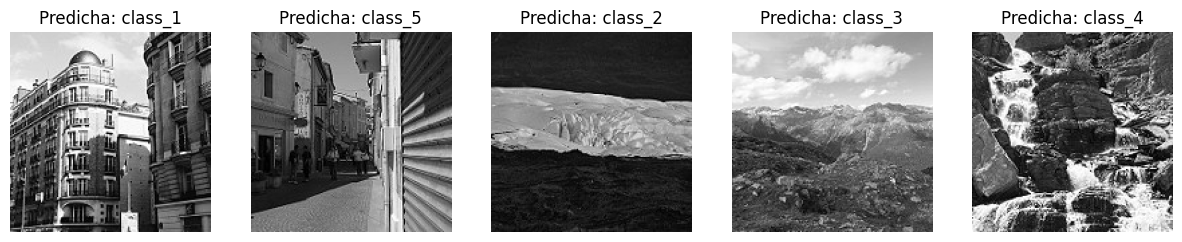

In [37]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Función para cargar las imágenes desde una carpeta
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Cargar el modelo entrenado
model = load_model('/content/modelo_entrenado.h5')

# Ruta de la carpeta que contiene las imágenes que deseas clasificar
pred_folder = '/content/seg_pred/seg_pred'

# Cargar las imágenes
pred_images = load_images_from_folder(pred_folder)

# Preprocesar las imágenes
def preprocess_images(images):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, (100, 100))
        processed_images.append(resized_img)
    return processed_images

pred_images_processed = preprocess_images(pred_images)

# Convertir las imágenes a matrices numpy y normalizar los valores de los píxeles
X_pred = np.array(pred_images_processed) / 255.0

# Cargar el diccionario label_to_index utilizado durante el entrenamiento
label_to_index = {0: 'class_1', 1: 'class_2', 2: 'class_3', 3: 'class_4', 4: 'class_5', 5: 'class_6'}

# Realizar predicciones en las imágenes cargadas
y_pred = model.predict(X_pred.reshape(-1, 100, 100, 1))

# Obtener las etiquetas predichas para cada imagen
predicted_labels = np.argmax(y_pred, axis=1)

# Decodificar las etiquetas numéricas a etiquetas de clase
predicted_classes = [label_to_index[label] for label in predicted_labels]

# Visualizar algunas de las imágenes junto con las etiquetas predichas
num_images_to_show = 5
selected_indices = np.random.choice(len(pred_images), num_images_to_show, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(pred_images[idx], cmap='gray')
    plt.title(f"Predicha: {predicted_classes[idx]}")
    plt.axis('off')

plt.show()
